# 作业：从零开始构建三层神经网络分类器，实现图像分类

**导入基本库**

In [204]:
import numpy as np
# 调包自动导入Fashion_mnist数据集
from torchvision import datasets
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os
import pandas as pd

**导入Fashion-Mnist数据集**

In [2]:
# 导入数据集
trainset = datasets.FashionMNIST(root='E:\\3_硕士_复旦大学\\1-研一\\2-第二学期\\神经网络和深度学习\\作业\\作业1', train=True, download=True)
testset = datasets.FashionMNIST(root='E:\\3_硕士_复旦大学\\1-研一\\2-第二学期\\神经网络和深度学习\\作业\\作业1', train=False, download=True)

# 定义一个函数来转换PIL图像到NumPy数组，并归一化
def transform_to_normalized_np_array(image):
    np_image = np.array(image, dtype=np.float32) / 255.0  # 将图像转换为NumPy数组，并归一化
    return np_image.reshape(784)

# 将数据集转换为NumPy数组，并归一化
X_train = np.array([transform_to_normalized_np_array(img) for img, _ in trainset])
y_train = np.array([label for _, label in trainset])

X_test = np.array([transform_to_normalized_np_array(img) for img, _ in testset])
y_test = np.array([label for _, label in testset])

# 此时，X_train 和 X_test 是归一化后的图像数据，y_train 和 y_test 是对应的标签

**定义激活函数**

In [178]:
# 定义ReLU
def relu(Z):
    return np.maximum(0, Z)

# 定义Sigmoid
def Sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

# 定义softmax函数
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / expZ.sum(axis=1, keepdims=True)

**定义反向传播相关函数**

In [ ]:
# 定义交叉熵损失函数（含L2正则化）
def cross_entropy(Y, Y_hat, params, l2_reg=0.0):
    m = Y.shape[0]
    log_likelihood = -np.log(Y_hat[range(m), Y])
    loss = np.sum(log_likelihood) / m
    l2_cost = 0.5 * l2_reg * sum(np.sum(W**2) for W in [params['W1'], params['W2']])
    return loss + l2_cost

# 定义ReLU的反向传播
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

# SGD优化器（含动量优化、学习率下降）
class SGD:
    def __init__(self, params, grads, learning_rate=0.01, momentum=0.0, decay_lr = 0.95):
        self.params = params
        self.lr = learning_rate
        self.momentum = momentum
        self.grads = grads
        self.decay_rate = decay_lr
        self.velocity = {}
        self.velocity = {k: np.zeros_like(v) for k, v in self.params.items()}

    def step(self, l2_reg=0.0):
        for key in self.params.keys():
            if 'W' in key:  # Only weights, not biases
                dW = self.grads['d' + key] + l2_reg * self.params[key]
                if self.momentum:
                    self.velocity[key] = self.momentum * self.velocity[key] - self.lr * dW
                    self.params[key] += self.velocity[key]
                else:
                    self.params[key] -= self.lr * dW
            else:  # For biases
                self.params[key] -= self.lr * self.grads['d' + key]
        self.lr *= self.decay_rate

**定义模型**

In [167]:
class ThreeLayerNN:
    def __init__(self, input_size, hidden_size, output_size, init_params = None):
        if init_params:
            self.params = init_params
        else:
            self.params = {
                # 定义He初始化
                'W1': np.random.randn(input_size, hidden_size) / np.sqrt(input_size / 2),
                'b1': np.zeros((1, hidden_size)),
                'W2': np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size / 2),
                'b2': np.zeros((1, output_size))
            }
        # 初始化梯度
        self.grads = {
            'dW1': 0, 
            'db1': 0, 
            'dW2': 0, 
            'db2': 0
        }

    # 定义前向过程
    def forward(self, X):
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = softmax(Z2)
        self.forward_cache = (Z1, A1, Z2, A2)
        return A2
    
    # 定义梯度
    def backward(self, X, Y):
        Z1, A1, Z2, A2 = self.forward_cache
        m = Y.shape[0]

        # 计算输出层(softmax)的梯度
        dZ2 = A2
        dZ2[range(m), Y] -= 1
        dZ2 /= m

        # 计算第三层的权重和偏置梯度
        dW2 = np.dot(A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # 计算隐藏层激活后的梯度
        dA1 = np.dot(dZ2, self.params['W2'].T)
        # 计算ReLU激活前的梯度
        dZ1 = relu_backward(dA1, Z1)

        # 计算第一层的权重和偏置梯度
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.grads['dW1'] = dW1
        self.grads['db1'] = db1
        self.grads['dW2'] = dW2
        self.grads['db2'] = db2
        return 
    
    # 定义反向传播
    def update_params(self, optimizer, l2_reg):
        optimizer.step(l2_reg)

**定义准确率评估函数与绘图函数**

In [168]:
def accuracy(y_hat,y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # y_hat.shape[1]>1表示不止一个类别，每个类别有各自的概率   
        y_hat = np.argmax(y_hat, axis=1) # 求行最大值的索引
    cmp = y_hat == y # 先判断逻辑运算符==，再赋值给cmp，cmp为布尔类型的数据
    return float(sum(cmp)) # 求和       

# 可以评估在任意模型net的准确率
def evaluate_accuracy(net, X_test, y_test):
    """计算在指定数据集上模型的精度"""
    metric = Accumulator(2) # 正确预测数、预测总数，metric为累加器的实例化对象，里面存了两个数
    metric.add(accuracy(net.forward(X_test), y_test), len(X_test)) 
    return metric[0] / metric[1] # 分类正确的样本数 / 总样本数

# Accumulator实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:
    """在n个变量上累加"""
    def __init__(self,n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a+float(b) for a,b in zip(self.data,args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包....
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]

# 定义绘图坐标轴
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# 定义运行时间函数
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

# 绘图函数
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def save_model_weights(params, filename='model_weights.npy'):
    np.save(filename, params)

**定义训练函数**

In [251]:
# 每个epoch对数据集进行shuffle
def shuffle_data(X_train, Y_train):
    perm = np.random.permutation(len(X_train))
    return X_train[perm], Y_train[perm]

# 训练函数
def train(X_train, y_train, X_test, y_test, model, optimizer, batch_size, epoch, l2_reg=0.0, save_threshold = 0.0):    
    
    '''设置动图生成函数以及计时器'''
    animator = Animator(xlabel='epoch', xlim=[1, epoch],
                            legend=['train loss', 'train acc', 'test acc'],ylim=[0,1])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer= Timer()
    
    '''训练过程'''
    for epoch in range(epoch):
        # count = 0
        X, Y = shuffle_data(X_train, y_train)  # Shuffle训练数据
        metric = Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            Y_batch = Y[i:i+batch_size]
            timer.start()
            y_hat= model.forward(X_batch)
            accu_count = accuracy(y_hat, Y_batch)
            loss = cross_entropy(Y_batch, y_hat, model.params, l2_reg)
            model.backward(X_batch, Y_batch)
            model.update_params(optimizer, l2_reg)
            metric.add(loss * batch_size, accu_count, batch_size)
            timer.stop()
        train_metrics = (metric[0] / metric[2], metric[1] / metric[2])

        # print(count)
        test_acc = evaluate_accuracy(model, X_test, y_test)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
        if test_acc > save_threshold:
            save_threshold = test_acc
            save_model_weights(model.params, filename=f'best_model_weights_{epoch+1}_{save_threshold:.4f}.npy')
            # print(f"Saved better model with acc: {save_threshold:.4f}")
            
    print(f'loss {metric[0] / metric[2]:.3f}, 训练精度{metric[1] / metric[2]:.3f}, 测试精度{test_acc:.3f}')
    print(f'{metric[2] * epoch / timer.sum():.1f} examples/sec,平均每轮运行时间 {timer.sum() / epoch:.3f} sec')

**训练模型**

loss 0.221, 训练精度0.921, 测试精度0.850
5352.1 examples/sec,平均每轮运行时间 11.211 sec


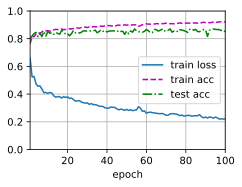

In [255]:
model = ThreeLayerNN(input_size=784, hidden_size=225, output_size=10, init_params = None)
sgd = SGD(params = model.params, grads = model.grads, learning_rate = 0.1, momentum = 0.9, decay_lr = 1)
train(X_train, y_train, X_test, y_test, model, sgd, batch_size = 50, epoch = 100, l2_reg=0, save_threshold = 0.0)

**参数可视化**

In [237]:
def visualize_weights(weights, img_shape=(28, 28), figsize=(10, 10)):
    if weights.shape[0] != img_shape[0] * img_shape[1]:
        raise ValueError("权重的第一个维度与预期的图像尺寸不匹配。")

    # 计算需要的网格大小
    grid_size = int(np.ceil(np.sqrt(weights.shape[1])))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    
    # 标准化权重以改善视觉效果
    weight_min = weights.min()
    weight_max = weights.max()
    
    for i, ax in enumerate(axes.flat):
        if i < weights.shape[1]:
            # 重塑权重以匹配图像尺寸
            img = weights[:, i].reshape(img_shape)
            
            # 标准化图像
            img = (img - weight_min) / (weight_max - weight_min)
            
            ax.imshow(img, cmap='gray', interpolation='nearest')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.show()

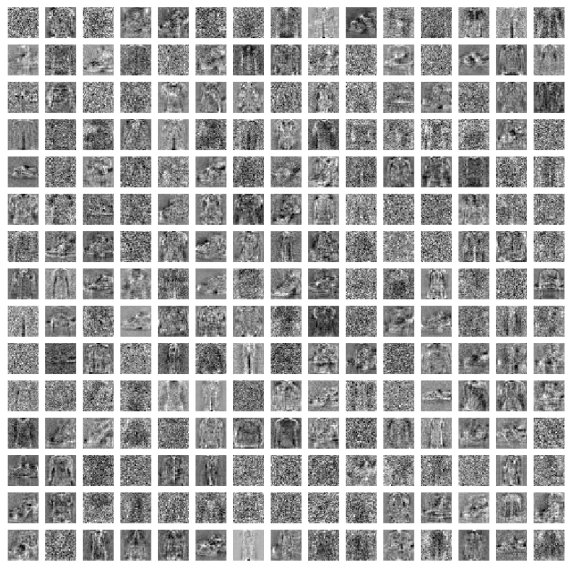

In [241]:
# 可视化W1参数
visualize_weights(model.params['W1'])

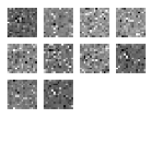

In [243]:
# 可视化W2参数
visualize_weights(model.params['W2'], img_shape=(15, 15), figsize=(2.5, 2.5))

**使用已保存参数测试模型**

In [ ]:
# 加载保存的模型参数
def load_model_weights(filename='model_weights.npy'):
    return np.load(filename, allow_pickle=True).item()

# 找到directory地址下保存的模型参数中，test数据中正确率最高的模型对应的模型参数的文件地址
def find_maxnum_npy_files(directory):
    # 检查目录下所有的文件
    files = os.listdir(directory)

    # 筛选出所有以 .npy 结尾的文件
    npy_files = [file.split("_")[-1] for file in files if file.endswith('.npy')]
    maxnum = max(npy_files)
    for file in files:
        if file.endswith(maxnum):
            return os.path.join(directory, file)

# 读取num_samples个测试数据，进行前向计算以分类。再通过pandas进行结果评析。
def evaluate_samples(model, X_test, y_test, num_samples=50):
    """评估前 num_samples 个测试样本，返回预测结果和真实标签的 DataFrame"""
    predictions = []
    for i in range(num_samples):
        # 前向传播获得预测结果
        y_hat = model.forward(X_test[i].reshape(1, -1))
        predicted_label = np.argmax(y_hat, axis=1)
        predictions.append(predicted_label[0])

    # 创建 DataFrame 保存预测值和真实值
    data = {'Y_hat': predictions, 'y_test': y_test[:num_samples]}
    df = pd.DataFrame(data)
    return df

In [213]:
# 模型地址    
directory = r"E:\3_硕士_复旦大学\1-研一\2-第二学期\神经网络和深度学习\作业\作业1"
# test_acc最高的模型参数的文件地址
result_files = find_maxnum_npy_files(directory)
# 读取该模型参数
saved_params = load_model_weights(result_files)

print(f"导入参数文件: {os.path.basename(result_files)}")
# 导入模型参数
model = ThreeLayerNN(input_size=784, hidden_size=128, output_size=10, init_params=saved_params)
print(f"该参数对应的模型的正确率为：{evaluate_accuracy(model, X_test, y_test)}")

# 定义num_samples
num = 50
# 取出前50个y_test、Y_test_hat
result_df = evaluate_samples(model, X_test, y_test, num_samples=num)
count = result_df["Y_hat"].eq(result_df["y_test"]).sum()
print(f"在前{num}个测试数据中，正确分类个数为：{count}，正确比例为：{count/num:.2f}")
result_df.head(50)

导入参数文件: best_model_weights_43_0.8717.npy
该参数对应的模型的正确率为：0.8717
在前50个测试数据中，正确分类个数为：42，正确比例为：0.84


,Y_hat,y_test
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6
5,1,1
6,4,4
7,6,6
8,5,5
9,7,7
